# Combining PennyLane with Amazon Braket

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

<div class="alert alert-block alert-info">
<b>What is PennyLane?</b> <a href="https://pennylane.ai/install.html">PennyLane</a> is a Python library for differentiable programming of quantum computers, allowing you to train a quantum computer the same way as a neural network.
</div>

<div align="center"><img src="pl_braket.png"/></div>

PennyLane integrates with Amazon Braket to add additional features for quantum machine learning and optimization. This introductory tutorial walks you through how to train a quantum circuit using Amazon Braket simulators and PennyLane's automatic differentiation capabilities.

## Setup

PennyLane is already installed on Braket notebook instances. On a local machine, PennyLane can be installed by following [these](https://pennylane.ai/install.html) instructions. It can then be imported with:

In [2]:
import pennylane as qml
from pennylane import numpy as np

To use Braket as a backend in PennyLane, we have to create a PennyLane device. Here we will first create a device that uses the local Braket simulator that runs on your local laptop (or on the server that hosts this notebook).

In [3]:
wires = 2  # Number of qubits

dev = qml.device("braket.local.qubit", wires=wires)

Below we will also show you how to scale out simulations to the AWS cloud.

## Defining a circuit

We will choose a simple two-qubit circuit with two controllable rotations and a CNOT gate.

In [4]:
@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))

The ``qml.qnode(dev)`` decorator binds the circuit to the local Braket device. Now, every time that ``circuit()`` is called, the quantum computation defined in the function above will be executed with Braket.

<div class="alert alert-block alert-info">
<b>Note</b> PennyLane also supports automatic differentiation with PyTorch and TensorFlow <a href="https://pennylane.readthedocs.io/en/stable/introduction/interfaces.html">interfaces</a>. The choice of interface can be specified using:
<code>@qml.qnode(dev, interface="&lt;interface&gt;")</code>.
</div>

## Evaluating the circuit and accessing its gradient

Let's set some values for our controllable parameters:

In [5]:
params = np.array([0.1, 0.2], requires_grad=True)

The circuit can be evaluated with these parameters using

In [6]:
print("Expectation value of circuit:", circuit(params))

Expectation value of circuit: 0.9751703272018161


In [7]:
print("Drawing of circuit:\n")
print(qml.draw(circuit)(params))

Drawing of circuit:

0: ──RX(0.10)─╭●─┤     
1: ──RY(0.20)─╰X─┤  <Z>


A crucial element of machine learning and optimization is accessing the gradient of a model with respect to its parameters. This functionality is built into PennyLane:

In [8]:
dcircuit = qml.grad(circuit)

Here, ``dcircuit`` is a callable function that evaluates the gradient of the circuit, i.e., its partial derivatives with respect to the controllable parameters.

In [9]:
dcircuit(params)

array([-0.0978434 , -0.19767681])

## Training the circuit

Suppose we now want to minimize the output of the circuit by updating its parameters. This can be done using gradient-based optimization.

First, an optimizer is fixed:

In [10]:
opt = qml.GradientDescentOptimizer(stepsize=0.2)

The next step is to run the optimizer for a chosen number of iterations:

Minimized circuit output: -0.9999996577749632
Optimized parameters: [4.19618503e-04 3.14087965e+00]


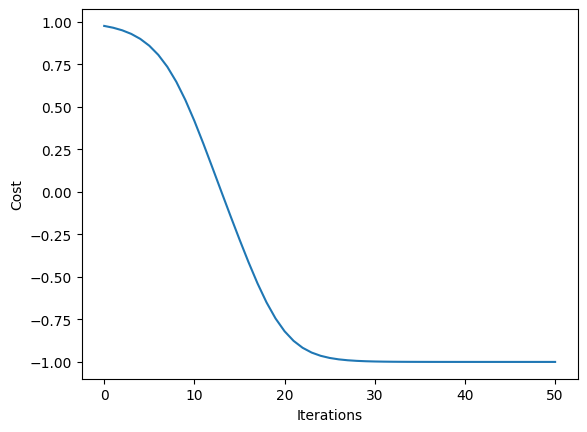

In [11]:
iterations = 50

costs = []

for i in range(iterations):
    params, cost = opt.step_and_cost(circuit, params)
    costs.append(cost)

# Visualize results
import matplotlib.pyplot as plt    
costs.append(circuit(params))
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")

print("Minimized circuit output:", circuit(params))
print("Optimized parameters:", params)

<div class="alert alert-block alert-info">
<b>Note</b> The circuit considered here is very simple and can be optimized easily by hand. However, the need for PennyLane's automatic differentiation capabilities becomes apparent as we make the problem more complicated, e.g., with more gates and different types of output measurement. In later demos, we will also see how Braket can be used to parallelize evaluation of the gradient, providing a turbocharger for quantum circuit training in PennyLane.
</div>

## Running circuits on Braket's on-demand simulator, SV1

So far we have used the local Braket simulator. This is a great choice for quick prototyping, but it is not suitable for large circuits with many qubits and does not provide a connection to quantum hardware.

Amazon Braket also provides access to on-demand, high-performance simulators and quantum processing units (QPUs) from different [providers](https://aws.amazon.com/braket/hardware-providers/). These devices can be accessed through PennyLane by changing a single line of code, unlocking the potential for machine learning and optimization on quantum hardware and high performance simulators!

<div align="center"><img src="remote-single-job.png"/></div>

Each remote Braket device can be selected through its [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html). The supported devices on Braket are listed [here](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html). For now, we will pick the on-demand SV1 simulator.
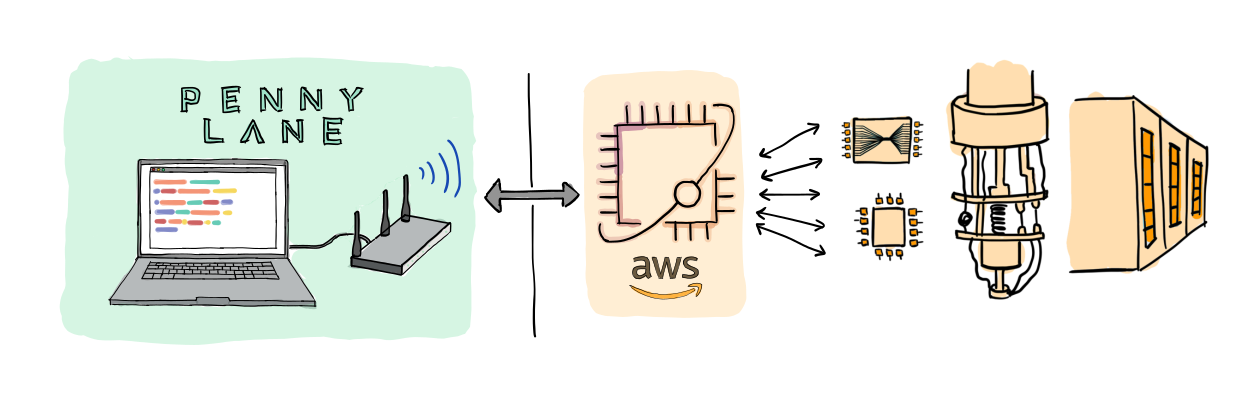

<div class="alert alert-block alert-warning">
<b>Caution:</b> Running hybrid algorithms on a QPU can take a long time and incur high <a href="https://aws.amazon.com/braket/pricing/">usage fees</a> charged to your AWS account.
</div>

In [12]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

In PennyLane, all remote Braket devices are then accessed through a single PennyLane device named ``braket.aws.qubit``.

In [13]:
dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=2)

A follow up [tutorial](./1_Parallelized_optimization_of_quantum_circuits.ipynb) shows you how to use the remote device to run multiple circuits in parallel, while the [QAOA tutorial](./2_Graph_optimization_with_QAOA.ipynb) takes a deeper dive into graph optimization, including using SV1 to optimize a 20-node graph.

Let's execute our circuit on SV1, as well as calculating the gradient:

In [14]:
@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))


dcircuit = qml.grad(circuit)

print("Result of circuit run on SV1:", circuit(params))
print("Result of gradient calculation on SV1:", dcircuit(params))

Result of circuit run on SV1: -0.9999996577749632
Result of gradient calculation on SV1: [ 0.00041962 -0.000713  ]


<div class="alert alert-block alert-info">
<b>What's next?</b> Check out the other tutorials in this folder to understand how Braket and PennyLane can be combined to solve a range of problems, from graph optimization to quantum chemistry.
</div>

In [15]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 2}, 'execution_duration': datetime.timedelta(microseconds=19000), 'billed_execution_duration': datetime.timedelta(seconds=6)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.008 USD
